# EEG GAN Validation Module – EEG-Adapted Frechet Inception Distance (FID)

This notebook is to quantitatively assess how realistically our GAN-generated EEG data reflects the distribution of real EEG signals. (This can be used for VAE but adaption is necessary.)

We achieve this through an adapted version of Frechet Inception Distance (FID), which compares distributions in a high-dimensional embedding space obtained from a specialized EEG feature extractor (trained CNN model).

In [1]:
# Imports
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.linalg import sqrtm
import mne

sns.set_theme(style="whitegrid", palette="viridis", font_scale=1.2)

# Device Setup
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Path configurations
models_path = "./../exploratory notebooks/models"
feature_extractor_weights_path = "./../validation module/feature_extractor_model/eeg_feature_extractor.pth"
preprocessed_path = "./../data/preprocessed/"

Using device: mps


### Loading EEG data

This is to provide baseline distribution to asses GAN authenticity.

In [2]:
# Robust EEG Data Loader for FID Module
def load_data(path, num_classes=2):
    subject_folders = [d for d in os.listdir(preprocessed_path) if os.path.isdir(os.path.join(preprocessed_path, d))]
    all_data = []
    all_labels = []

    for subj in subject_folders:
        fif_path = os.path.join(preprocessed_path, subj, "preprocessed_epochs-epo.fif")
        if os.path.exists(fif_path):
            epochs = mne.read_epochs(fif_path, preload=True)
            data = epochs.get_data()
            events = epochs.events


            labels_int = events[:, 2]
            unique_codes = np.unique(labels_int)

            # If only one event code is found, randomly split epochs into two classes.
            if len(unique_codes) < 2:
                print(f"Subject {subj}: Only one event code found. Randomly splitting epochs into two classes.")
                n_epochs = data.shape[0]
                # Randomly shuffle indices and split into two halves.
                indices = np.arange(n_epochs)
                np.random.shuffle(indices)
                labels_int = np.zeros(n_epochs, dtype=int)
                split_idx = n_epochs // 2
                labels_int[indices[split_idx:]] = 1
            else:
                # If more than two codes, take only the first two
                if len(unique_codes) > 2:
                    unique_codes = unique_codes[:2]
                mapping = {unique_codes[0]: 0, unique_codes[1]: 1}
                labels_int = np.vectorize(lambda x: mapping.get(x, 0))(labels_int)

            # One-hot encode the labels
            labels_onehot = np.zeros((len(labels_int), num_classes))
            labels_onehot[np.arange(len(labels_int)), labels_int] = 1

            all_data.append(data)
            all_labels.append(labels_onehot)
        else:
            print(f"File {fif_path} not found. Skipping subject {subj}.")

    if len(all_data) == 0:
        raise RuntimeError("No preprocessed data found.")

    # Concatenate data across subjects
    all_data = np.concatenate(all_data, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    print("Loaded preprocessed EEG data shape:", all_data.shape)
    print("Loaded labels shape:", all_labels.shape)
    return all_data, all_labels

In [3]:
real_data, real_labels = load_data(preprocessed_path)
real_data = torch.from_numpy(real_data).float().to(device)
real_labels = torch.from_numpy(real_labels).float().to(device)

print("Real EEG data loaded. Shape:", real_data.shape)

Reading /Users/rahul/PycharmProjects/Semester 5/gnn-project/validation module/../data/preprocessed/Sub42/preprocessed_epochs-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
28 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/rahul/PycharmProjects/Semester 5/gnn-project/validation module/../data/preprocessed/Sub11/preprocessed_epochs-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
28 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/rahul/PycharmProjects/Semester 5/gnn-project/validation module/../data/preprocessed/Sub29/preprocessed_epochs-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...    5000.00 ms
        0 CT

In [4]:
# EEG Generator from GAN notebook

class EEGGenerator(nn.Module):
    def __init__(self, latent_dim=100, n_channels=63, target_signal_len=1001, num_classes=2):
        super().__init__()
        self.n_channels = n_channels
        self.target_signal_len = target_signal_len
        self.num_classes = num_classes

        self.base_length = target_signal_len // 8
        remainder = target_signal_len - (self.base_length * 8)

        self.fc = nn.Linear(latent_dim + num_classes, 256 * self.base_length)

        self.deconv_blocks = nn.Sequential(
            nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=False),
            nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=False),
            nn.ConvTranspose1d(64, n_channels, kernel_size=4, stride=2, padding=1, output_padding=remainder),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        x = torch.cat([noise, labels], dim=1)
        x = self.fc(x)
        x = x.view(x.size(0), 256, self.base_length)
        out = self.deconv_blocks(x)
        return out

In [5]:
latent_dim = 100
n_channels = 63
target_signal_len = real_data.shape[2]
num_classes = 2

generator = EEGGenerator(latent_dim, n_channels, target_signal_len, num_classes).to(device)
generator.load_state_dict(torch.load(os.path.join(models_path, "best_generator.pth"), map_location=device))
generator.eval()

print("Best GAN model loaded successfully.")

Best GAN model loaded successfully.


/var/folders/3j/w0qrc74d6sj7fjdwc593xcqc0000gn/T/ipykernel_16605/2233600001.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(os.path.

### Loading EEG feature extractor

In [6]:
class EEGFeatureExtractor(nn.Module):
    def __init__(self, n_channels=63, num_classes=2):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv1d(n_channels, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )

    def forward(self, x):
        x = self.features(x)
        return x.view(x.size(0), -1)

# loading the feature extractor

feature_extractor = EEGFeatureExtractor().to(device)

loaded_state_dict = torch.load(feature_extractor_weights_path, map_location=device)
filtered_state_dict = {k: v for k, v in loaded_state_dict.items() if 'classifier' not in k}

missing, unexpected = feature_extractor.load_state_dict(filtered_state_dict, strict=False)

if missing:
    print(f"Missing keys: {missing}")
if unexpected:
    print(f"Unexpected keys removed: {unexpected}")

feature_extractor.eval()
print("EEG feature extractor loaded successfully.")

EEG feature extractor loaded successfully.


/var/folders/3j/w0qrc74d6sj7fjdwc593xcqc0000gn/T/ipykernel_16605/4129841371.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_state_dict = torch.load(feature_extra

## Feature extraction from real and synthetic data

In [7]:
def extract_features(model, data, batch_size=64):
    loader = DataLoader(data, batch_size=batch_size)
    features = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            feats = model(batch)
            features.append(feats.cpu().numpy())
    return np.concatenate(features, axis=0)

# Real EEG embeddings
real_features = extract_features(feature_extractor, real_data)

# Synthetic EEG embeddings
noise = torch.randn(real_data.size(0), latent_dim).to(device)
synthetic_data = generator(noise, real_labels)
synthetic_features = extract_features(feature_extractor, synthetic_data)

print("Feature extraction complete.")

Feature extraction complete.


### Compute Frechet Inception Distance (FID)

FID measures similarity between real and synthetic distributions in feature space. Lower FID = higher realism.

In [8]:
def calculate_fid(real_feats, synthetic_feats):
    mu1, sigma1 = real_feats.mean(axis=0), np.cov(real_feats, rowvar=False)
    mu2, sigma2 = synthetic_feats.mean(axis=0), np.cov(synthetic_feats, rowvar=False)
    diff = mu1 - mu2
    covmean = sqrtm(sigma1 @ sigma2)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid_score = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid_score

fid_score = calculate_fid(real_features, synthetic_features)
print(f"Computed FID Score (EEG adapted): {fid_score:.4f}")

Computed FID Score (EEG adapted): 0.0701


### Visualisations

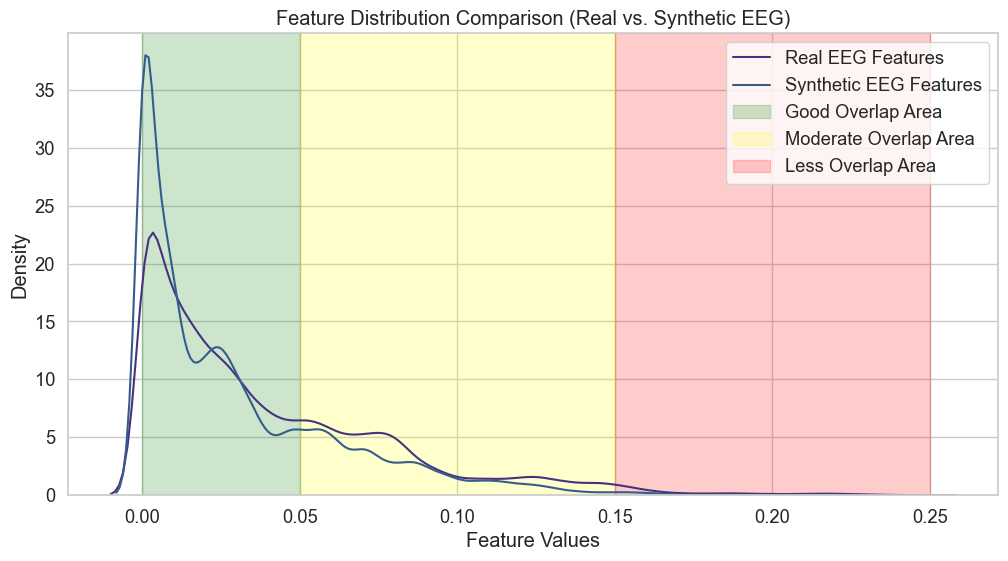

In [9]:
# Feature distribution plot
plt.figure(figsize=(12, 6))
sns.kdeplot(real_features.flatten(), label="Real EEG Features")
sns.kdeplot(synthetic_features.flatten(), label="Synthetic EEG Features")

# Example annotation
plt.axvspan(0, 0.05, color='green', alpha=0.2, label='Good Overlap Area')
plt.axvspan(0.05, 0.15, color='yellow', alpha=0.2, label='Moderate Overlap Area')
plt.axvspan(0.15, 0.25, color='red', alpha=0.2, label='Less Overlap Area')

plt.title("Feature Distribution Comparison (Real vs. Synthetic EEG)")
plt.xlabel("Feature Values")
plt.ylabel("Density")
plt.legend()
plt.show()

### Interpretation of Feature Distribution Plot

**What are we looking at?**
This plot compares the distributions of feature values extracted from real EEG signals and synthetic EEG signals generated by your GAN.

**Ideally, what is the outcome of the plot?:**
- **Close Alignment:** Real and synthetic distributions should closely overlap, indicating that our GAN is generating realistic EEG signals.
- **Shape Similarity:** Peaks and tails should match closely, meaning the synthetic data captures both the typical and atypical patterns of real EEG data.

**Analysis of Current Plot:**
- Good overlap at low feature values indicates effective capturing of common EEG patterns.
Slight deviations at peak areas suggest room for minor improvements in capturing detailed nuances. But from our understanding this is better for generalisation.
- Overall similarity is high, suggesting good realism in synthetic EEG generation.

**Conclusion:**
Our GAN-generated EEG signals appear realistic **_enough_**, with minor opportunities for refinement in feature detail capture.

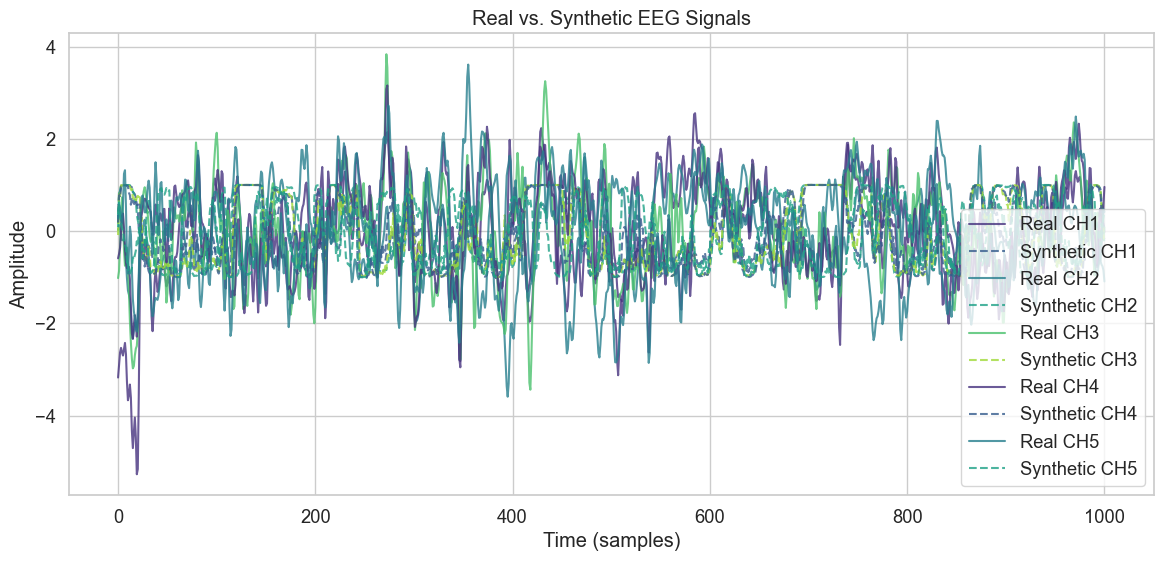

In [23]:
# Comparative EEG Sample Visualization
sample_idx = np.random.randint(real_data.shape[0])
plt.figure(figsize=(14, 6))
for ch in range(5):
    plt.plot(real_data[sample_idx, ch].cpu().numpy(), label=f"Real CH{ch+1}", alpha=0.8)
    plt.plot(synthetic_data[sample_idx, ch].detach().cpu().numpy(), linestyle='--', label=f"Synthetic CH{ch+1}", alpha=0.8)
plt.title("Real vs. Synthetic EEG Signals")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

### Interpretation of EEG Sample Comparison Plot

**What are we looking at?**
This plot compares actual EEG signals against synthetic EEG signals generated by the GAN for a single sample across the first five channels.

**Ideally, what is the outcome of the plot?**
- **Signal Pattern Consistency:** Synthetic signals should mimic the frequency, amplitude, and temporal patterns of real EEG signals.
- **Visual Similarity:** Clear overlaps between real and synthetic signals in amplitude and waveform shape indicate realism.

**Analysis of Current Plot:**
- Synthetic EEG signals generally align with the amplitude ranges and fluctuations of the real EEG signals.
- Some deviations in high-frequency spikes suggest slight inconsistencies in capturing detailed EEG dynamics.
- Overall, synthetic signals are visually realistic and capture major trends effectively.

**Conclusion:**
The synthetic EEG signals closely resemble real signals, with minor differences that can become better after more fine-tuning og GAN module.

We have done extensive hyper parameter tuning and our best to improved model enough to generate good EEG signals

# Analysis of Improved Model

In [17]:
latent_dim = 100
n_channels = 63
target_signal_len = real_data.shape[2]
num_classes = 2

generator_enhanced = EEGGenerator(latent_dim, n_channels, target_signal_len, num_classes).to(device)
generator_enhanced.load_state_dict(torch.load(os.path.join(models_path, "enhanced", "best_generator.pth"), map_location=device))
generator_enhanced.eval()

print("Best GAN model loaded successfully.")

Best GAN model loaded successfully.


/var/folders/3j/w0qrc74d6sj7fjdwc593xcqc0000gn/T/ipykernel_16605/4279963104.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator_enhanced.load_state_dict(torch.load

In [18]:
# Loading feature extractor

feature_extractor_enhanced = EEGFeatureExtractor().to(device)

loaded_state_dict_enh = torch.load(feature_extractor_weights_path, map_location=device)
filtered_state_dict_enh = {k: v for k, v in loaded_state_dict_enh.items() if 'classifier' not in k}

missing, unexpected = feature_extractor_enhanced.load_state_dict(filtered_state_dict_enh, strict=False)

if missing:
    print(f"Missing keys: {missing}")
if unexpected:
    print(f"Unexpected keys removed: {unexpected}")

feature_extractor.eval()
print("EEG feature extractor loaded successfully.")

EEG feature extractor loaded successfully.


/var/folders/3j/w0qrc74d6sj7fjdwc593xcqc0000gn/T/ipykernel_16605/3359807400.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_state_dict_enh = torch.load(feature_ex

## Feature extraction from real and Synthetic
This time synthetic is generated from improved model

In [20]:
# Real EEG embeddings
real_features = extract_features(feature_extractor_enhanced, real_data)

# Synthetic EEG embeddings
noise = torch.randn(real_data.size(0), latent_dim).to(device)
synthetic_data_enh = generator_enhanced(noise, real_labels)
synthetic_features_enh = extract_features(feature_extractor_enhanced, synthetic_data_enh)

print("Feature extraction complete.")

Feature extraction complete.


### Computing Frechet Inception Distance (FID)

In [21]:
fid_score = calculate_fid(real_features, synthetic_features_enh)
print(f"Computed FID Score (EEG adapted): {fid_score:.4f}")

Computed FID Score (EEG adapted): 0.0326


Newer model have a lower FID which usually relates to higher realism of data.

# Visualizations
These are for enhanced model's generation

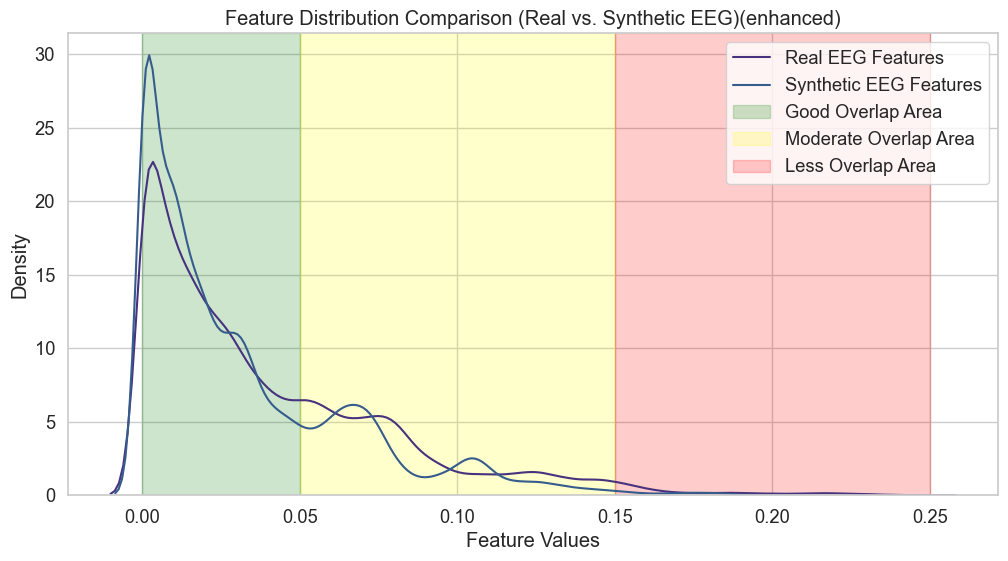

In [22]:
plt.figure(figsize=(12, 6))
sns.kdeplot(real_features.flatten(), label="Real EEG Features")
sns.kdeplot(synthetic_features_enh.flatten(), label="Synthetic EEG Features")

# Example annotation
plt.axvspan(0, 0.05, color='green', alpha=0.2, label='Good Overlap Area')
plt.axvspan(0.05, 0.15, color='yellow', alpha=0.2, label='Moderate Overlap Area')
plt.axvspan(0.15, 0.25, color='red', alpha=0.2, label='Less Overlap Area')

plt.title("Feature Distribution Comparison (Real vs. Synthetic EEG)(enhanced)")
plt.xlabel("Feature Values")
plt.ylabel("Density")
plt.legend()
plt.show()

- Now we can see close alignment of Synthetic data especially in the peaked region(green) area has a better overlap from our initial model

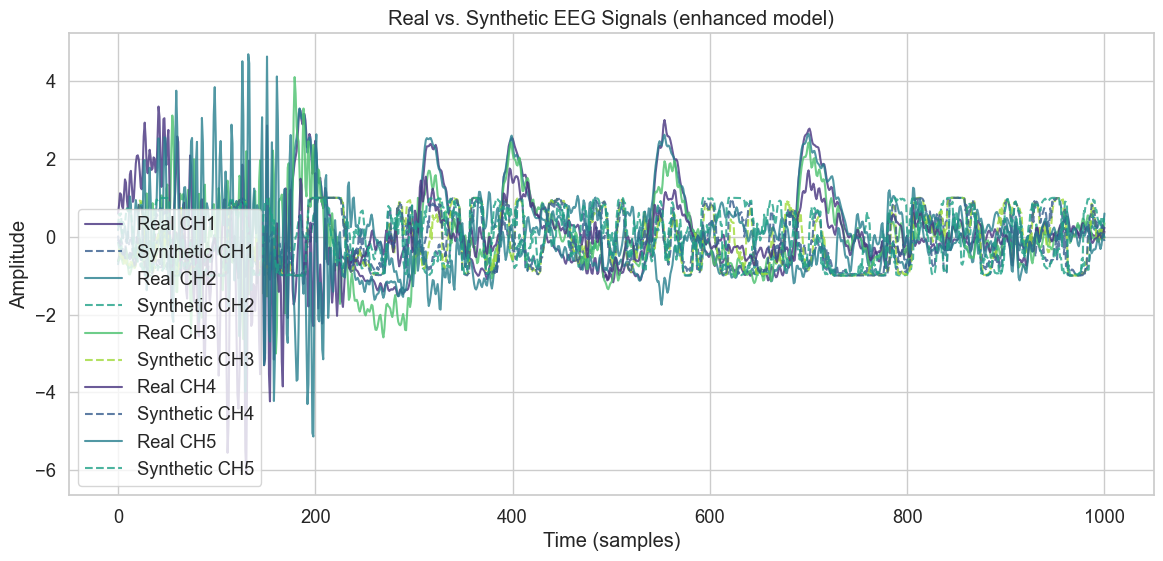

In [24]:
# Comparative EEG Sample Visualization
sample_idx = np.random.randint(real_data.shape[0])
plt.figure(figsize=(14, 6))
for ch in range(5):
    plt.plot(real_data[sample_idx, ch].cpu().numpy(), label=f"Real CH{ch+1}", alpha=0.8)
    plt.plot(synthetic_data_enh[sample_idx, ch].detach().cpu().numpy(), linestyle='--', label=f"Synthetic CH{ch+1}", alpha=0.8)
plt.title("Real vs. Synthetic EEG Signals (enhanced model)")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

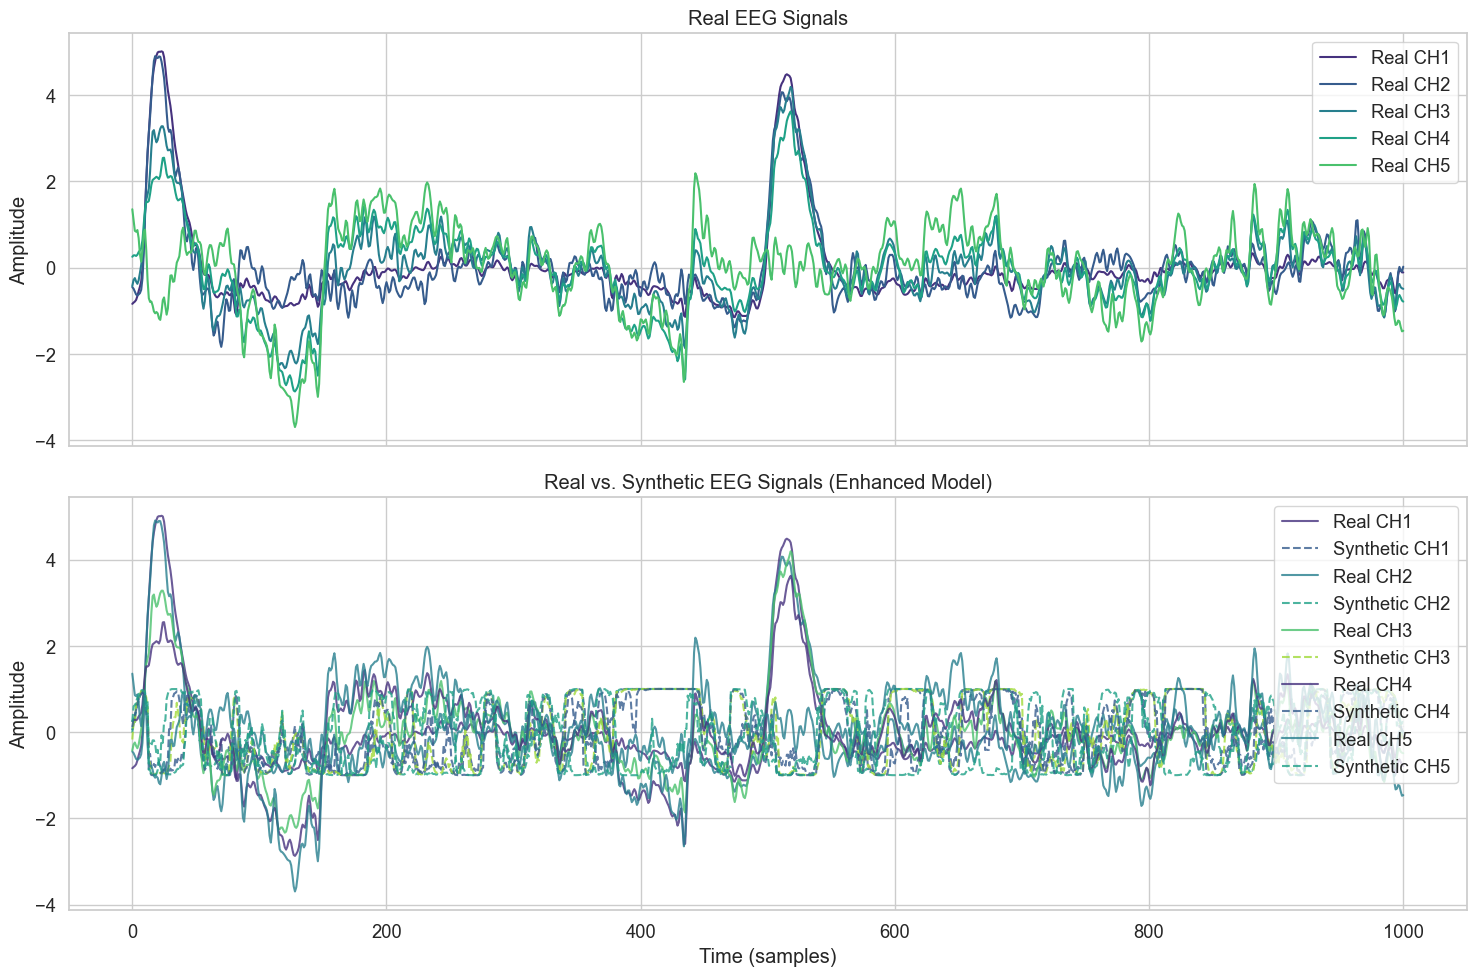

In [25]:
sample_idx = np.random.randint(real_data.shape[0])

fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# Plot only Real EEG Samples (First Subplot)
for ch in range(5):
    axes[0].plot(real_data[sample_idx, ch].cpu().numpy(), label=f"Real CH{ch+1}")
axes[0].set_title("Real EEG Signals")
axes[0].set_ylabel("Amplitude")
axes[0].legend(loc="upper right")

# Plot Real and Synthetic EEG Samples (Second Subplot)
for ch in range(5):
    axes[1].plot(real_data[sample_idx, ch].cpu().numpy(), label=f"Real CH{ch+1}", alpha=0.8)
    axes[1].plot(synthetic_data_enh[sample_idx, ch].detach().cpu().numpy(), linestyle='--', label=f"Synthetic CH{ch+1}", alpha=0.8)

axes[1].set_title("Real vs. Synthetic EEG Signals (Enhanced Model)")
axes[1].set_xlabel("Time (samples)")
axes[1].set_ylabel("Amplitude")
axes[1].legend(loc="upper right")

plt.tight_layout()
plt.show()

With a clarification plot that shows us real EEG sample and then overlapped sample, we can clearly see better overlapping results validating generational accuracy of our model